In [1]:
import data_utils_v2 as data_utils
import pandas as pd
import numpy as np

dataset = data_utils.get_dataset()
cie10_df = pd.read_csv('datasets/CIE10.csv', sep = ';')
cie10_df['DESCRIPCION_COD_CIE_10_04'] = cie10_df['DESCRIPCION_COD_CIE_10_04'].apply(lambda value: value.lower())
dataset = pd.merge(left = dataset, right = cie10_df, how = 'left', left_on='CIE_10', right_on='DESCRIPCION_COD_CIE_10_04')


In [2]:

def to_year(value_range):
    if(value_range == 'no_cie10'):
        return -1
    
    num = int(value_range[:3])
    unit = value_range[-1]
    
    map_unit = {
        'A': num,
        'M': num / 12,
        'D': num / 365,
        'H': num / 8760
    }
    return int(map_unit[unit])

def get_edad_inf(value):
    value_range = {
        '999': -1,
        'de 0 a 5 años': 0,
        'de 13 a 17 años': 13,
        'de 18 a 24 años': 18,
        'de 25 a 29 años': 25,
        'de 30 a 37 años': 30,
        'de 38 a 49 años': 38,
        'de 50 a 62 años': 50,
        'de 6 a 12 años': 6,
        'mayor de 63 años': 63
            }
    return value_range.get(value, -1)

def get_edad_sup(value):
    value_range = {
        '999': -1,
        'de 0 a 5 años': 5,
        'de 13 a 17 años': 17,
        'de 18 a 24 años': 24,
        'de 25 a 29 años': 29,
        'de 30 a 37 años': 37,
        'de 38 a 49 años': 49,
        'de 50 a 62 años': 62,
        'de 6 a 12 años': 12,
        'mayor de 63 años': 120
            }
    return value_range.get(value, -1)

def in_range(row):
    return row['AFEC_EDADR_INF'] >= row['LIMITE_INFERIOR_EDAD_Y'] and  row['AFEC_EDADR_SUP'] < row['LIMITE_SUPERIOR_EDAD_Y']

def cie10_sexo(value):
    if(value == 1 or value == 2):
        return True
    return False


In [3]:


dataset = dataset.drop(['CIE_10', 'NOMBRE_CAPITULO', 'DESCRIPCION_COD_CIE_10_03', 'DESCRIPCION_COD_CIE_10_04'], axis = 1)

cie10_columns = [
    'CAPITULO', 
    'COD_CIE_10_03', 
    'COD_CIE_10_04', 
    'SEXO', 
    'LIMITE_INFERIOR_EDAD', 
    'LIMITE_SUPERIOR_EDAD']

dataset[cie10_columns] = dataset[cie10_columns].replace(np.nan, 'no_cie10', regex=True)
dataset = dataset[dataset['CAPITULO'] != 'no_cie10']

dataset['CIE10_SEXO'] = dataset['SEXO'].apply(cie10_sexo)
dataset['LIMITE_INFERIOR_EDAD_Y'] = dataset['LIMITE_INFERIOR_EDAD'].apply(to_year)
dataset['LIMITE_SUPERIOR_EDAD_Y'] = dataset['LIMITE_SUPERIOR_EDAD'].apply(to_year)
dataset['AFEC_EDADR_INF'] = dataset['AFEC_EDADR'].apply(get_edad_inf)
dataset['AFEC_EDADR_SUP'] = dataset['AFEC_EDADR'].apply(get_edad_sup)
dataset['CIE10_RANGO_EDAD'] = dataset.apply(in_range, axis=1)

dataset = dataset.drop(
    [
        'SEXO',
        'LIMITE_INFERIOR_EDAD', 
        'LIMITE_SUPERIOR_EDAD', 
        'LIMITE_INFERIOR_EDAD_Y', 
        'LIMITE_SUPERIOR_EDAD_Y',
        'AFEC_EDADR'

    ], axis = 1
)


print(dataset.shape)
dataset[
    [
        'AFEC_GENERO',
        'CIE10_SEXO',
        'CIE10_RANGO_EDAD',
        'AFEC_EDADR_INF', 
        'AFEC_EDADR_SUP',

    ]
].head()


(175360, 51)


,AFEC_GENERO,CIE10_SEXO,CIE10_RANGO_EDAD,AFEC_EDADR_INF,AFEC_EDADR_SUP
4,hombre,False,False,13,17
7,hombre,False,False,13,17
18,hombre,False,False,13,17
19,mujer,False,False,6,12
22,hombre,False,False,6,12


In [4]:
'''
import numpy as np
codes = dataset[['ENT_COD_DEPTO', 'ENT_MPIO']].drop_duplicates().to_dict('records')
codes
codes_depto = {}
for code in codes:
    codes_depto[code['ENT_MPIO']] = code['ENT_COD_DEPTO']
dataset['AFEC_COD_DPTO'] = dataset['AFEC_MPIO'].apply(lambda value: codes_depto.get(value, '999'))
dataset = dataset.drop(['AFEC_DPTO'], axis = 1)
'''

"\nimport numpy as np\ncodes = dataset[['ENT_COD_DEPTO', 'ENT_MPIO']].drop_duplicates().to_dict('records')\ncodes\ncodes_depto = {}\nfor code in codes:\n    codes_depto[code['ENT_MPIO']] = code['ENT_COD_DEPTO']\ndataset['AFEC_COD_DPTO'] = dataset['AFEC_MPIO'].apply(lambda value: codes_depto.get(value, '999'))\ndataset = dataset.drop(['AFEC_DPTO'], axis = 1)\n"

In [5]:
dataset = data_utils.clean_afec_dpto(dataset)
dataset = data_utils.clean_riesgo_vida(dataset)
dataset = data_utils.remove_features(dataset)
dataset = dataset.reset_index()
dataset = dataset.drop(['index'], axis = 1)
print(dataset.shape)

(175360, 41)


In [6]:
labels = dataset[['RIESGO_VIDA']]
features = dataset.drop(['RIESGO_VIDA'], axis = 1)

encoded_features = data_utils.encode_features(features, labels)

encoded_features['RIESGO_VIDA'] = labels

--- 208.24873900413513 seconds ---


0.17540495414033624


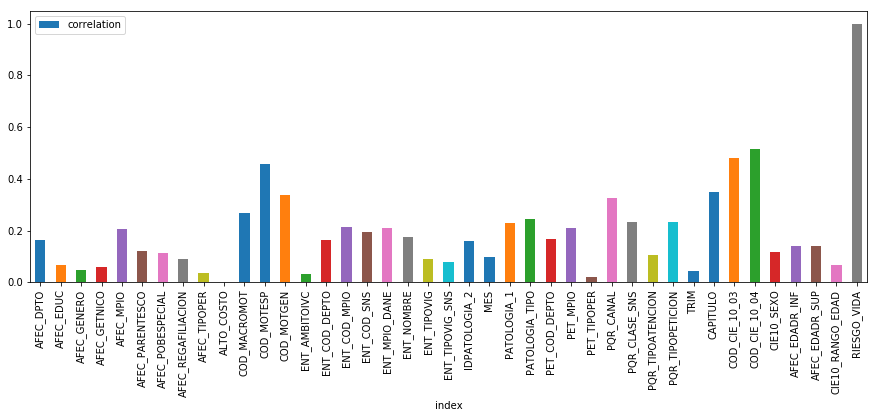

In [7]:
def feature_correlations(df, feature):
    data_corr = df.corr()
    data_corr = data_corr.loc[feature].to_frame(name = 'correlation').reset_index()
    data_corr.plot(kind = 'bar', x = 'index', y = 'correlation', figsize=(15,5))
    print(data_corr[data_corr['index'] != feature]['correlation'].mean())

feature_correlations(encoded_features, 'RIESGO_VIDA')

In [8]:
display(encoded_features.head(n = 5))

,AFEC_DPTO,AFEC_EDUC,AFEC_GENERO,AFEC_GETNICO,AFEC_MPIO,AFEC_PARENTESCO,AFEC_POBESPECIAL,AFEC_REGAFILIACION,AFEC_TIPOPER,ALTO_COSTO,...,PQR_TIPOPETICION,TRIM,CAPITULO,COD_CIE_10_03,COD_CIE_10_04,CIE10_SEXO,AFEC_EDADR_INF,AFEC_EDADR_SUP,CIE10_RANGO_EDAD,RIESGO_VIDA
0,0.425153,0.400555,0.458335,0.42859,0.454756,0.537595,0.532278,0.419117,0.431765,0.426038,...,0.455397,0.405202,0.420753,0.659895,0.795501,0.407151,0.436994,0.436994,0.413772,1
1,0.552813,0.436647,0.458335,0.42859,0.557585,0.537595,0.419145,0.419117,0.431765,0.426038,...,0.455397,0.405202,0.370675,0.203957,0.111111,0.407151,0.436994,0.436994,0.413772,0
2,0.491303,0.435185,0.458335,0.42859,0.485267,0.537595,0.419145,0.380646,0.431765,0.426038,...,0.455397,0.405202,0.453680,0.457447,0.466667,0.407151,0.436994,0.436994,0.413772,0
3,0.552813,0.400555,0.412468,0.42859,0.527363,0.426399,0.532278,0.419117,0.431765,0.426038,...,0.455397,0.405202,0.248912,0.529412,0.727259,0.407151,0.435873,0.435873,0.413772,1
4,0.411579,0.400555,0.458335,0.42859,0.401531,0.383166,0.419145,0.419117,0.431765,0.426038,...,0.455397,0.405202,0.311155,0.134942,0.130781,0.407151,0.435873,0.435873,0.413772,0


In [9]:
encoded_features.to_csv("datasets/cie10_dataset.csv", index = False)